In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append('../Utils')
from ML_training_utils_tools import evaluate_model

datapath='../Dataset/'
df_train=pd.read_csv(datapath+'train_data_for_modeling(no_standardization).csv')
print(f'Successfully loaded train data, the shape is {df_train.shape}')

with open(datapath+'all_final_features.json', 'r') as f:
    all_final_features=json.load(f)

feature_cols=[col for col in all_final_features if col not in ['RESALE_PRICE', 'LOG_RESALE_PRICE']]

X=df_train[feature_cols]
y=df_train['RESALE_PRICE']

X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42)
print('Successfully split the data')
print(f'The shape of train data is {X_train.shape},the shape of valid data is {X_valid.shape}')


In [ ]:
#1. Baseline Model (Default Parameters)
baseline_model=XGBRegressor(random_state=42,n_jobs=-1)
baseline_model.fit(X_train,y_train)

y_pred_train=baseline_model.predict(X_train)
y_pred_valid=baseline_model.predict(X_valid)

train_rmse,train_mae,train_r2=evaluate_model(y_train,y_pred_train,'Train')
baseline_rmse,baseline_mae,baseline_r2=evaluate_model(y_valid,y_pred_valid,'Validation')

print("\n==overfitting check==" )

rmse_gap = baseline_rmse - train_rmse
rmse_gap_pct = (rmse_gap / train_rmse) * 100

print(f"RMSE gap: ${rmse_gap:,.2f} ({rmse_gap_pct:.1f}%)")

if rmse_gap_pct > 20:
    print(" warning: model may overfitting (validation error is higher than training error by more than 20%)")
    print(" suggestion: increase regularization, reduce model complexity")
elif rmse_gap_pct > 10:
    print(" warning: model may overfitting (validation error is higher than training error by 10-20%)")
    print(" suggestion: acceptable, but you can try to adjust the hyperparameters")
else:
    print(" good: model has good generalization ability")

print(f"\n final evaluation metrics (based on validation set):")
print(f"   RMSE: ${baseline_rmse:,.2f}")
print(f"   MAE:  ${baseline_mae:,.2f}")
print(f"   R²:   {baseline_r2:.4f}")

In [ ]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 20 Most Important Features ===")
print(feature_importance.head(20))



plt.figure(figsize=(10, 8))
feature_importance.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Feature Importances (Baseline Model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [4]:
import time
#2.Random Search
print(f"Rapid Random Search -- Coarse exploration")
param_distributions={
    "n_estimators":[200,500,800,1000,1200,1500],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    "max_depth":[3,4,5,6,7,8,9,10],
    "subsample":[0.5,0.6,0.7,0.8,0.9,1.0],
    "colsample_bytree":[0.5,0.6,0.7,0.8,0.9,1.0],
    "gamma":[0,0.1,0.2,0.3,0.4,0.5],
    "reg_alpha":[0,0.01,0.05,0.1,0.5,1.0],
    'reg_lambda': [0.5, 1, 1.5, 2, 3]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=1),
    param_distributions=param_distributions,
    n_iter=50,   
    cv=5,      
    scoring='neg_root_mean_squared_error',  
    verbose=2,  
    random_state=42,
    n_jobs=-1   
)
print("Start the Random Search...")
start_time = time.time()

random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print(f"\n Random Search completed! Time taken: {elapsed_time/60:.1f} minutes")


best_params_random = random_search.best_params_
print(f"\nBest parameters (Random Search):")
for param, value in best_params_random.items():
    print(f"  {param}: {value}")


best_model_random = random_search.best_estimator_
y_pred_val_random = best_model_random.predict(X_valid)
random_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_val_random))
random_mae = mean_absolute_error(y_valid, y_pred_val_random)
random_r2 = r2_score(y_valid, y_pred_val_random)

print(f"\nRandom Search - Validation Performance:")
print(f"  RMSE: ${random_rmse:,.2f}")
print(f"  MAE:  ${random_mae:,.2f}")
print(f"  R²:   {random_r2:.4f}")
print(f"\nImprovement: ${31133.04 - random_rmse:,.2f} (vs Baseline)")

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.15, max_depth=8, n_estimators=800, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=  29.5s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.15, max_depth=8, n_estimators=800, reg_alpha=0.1, reg_lambda=3, subsample=0.6; total time=  29.0s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.03, max_depth=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  40.6s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.03, max_depth=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  41.5s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.03, max_depth=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  40.8s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=0.03, max_depth=8, n_estimators=1000, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  41.5s
[CV] END colsample_bytree=0.9, gamma=0.3, learning_rate=

In [10]:
import pandas as pd, json, pathlib as pl
out = pl.Path('/Users/yangkexin/Documents/CS5228/Project/cs5228_PROJ/Models/LightGBM_notebook')
out.mkdir(parents=True, exist_ok=True)

cv_xgb = pd.DataFrame(random_search.cv_results_)  # 或 rs_xgb.cv_results_
cv_xgb.to_csv(out/'xgb_cv_results.csv', index=False)
(out/'xgb_best_params.json').write_text(json.dumps(random_search.best_params_, indent=2))

167

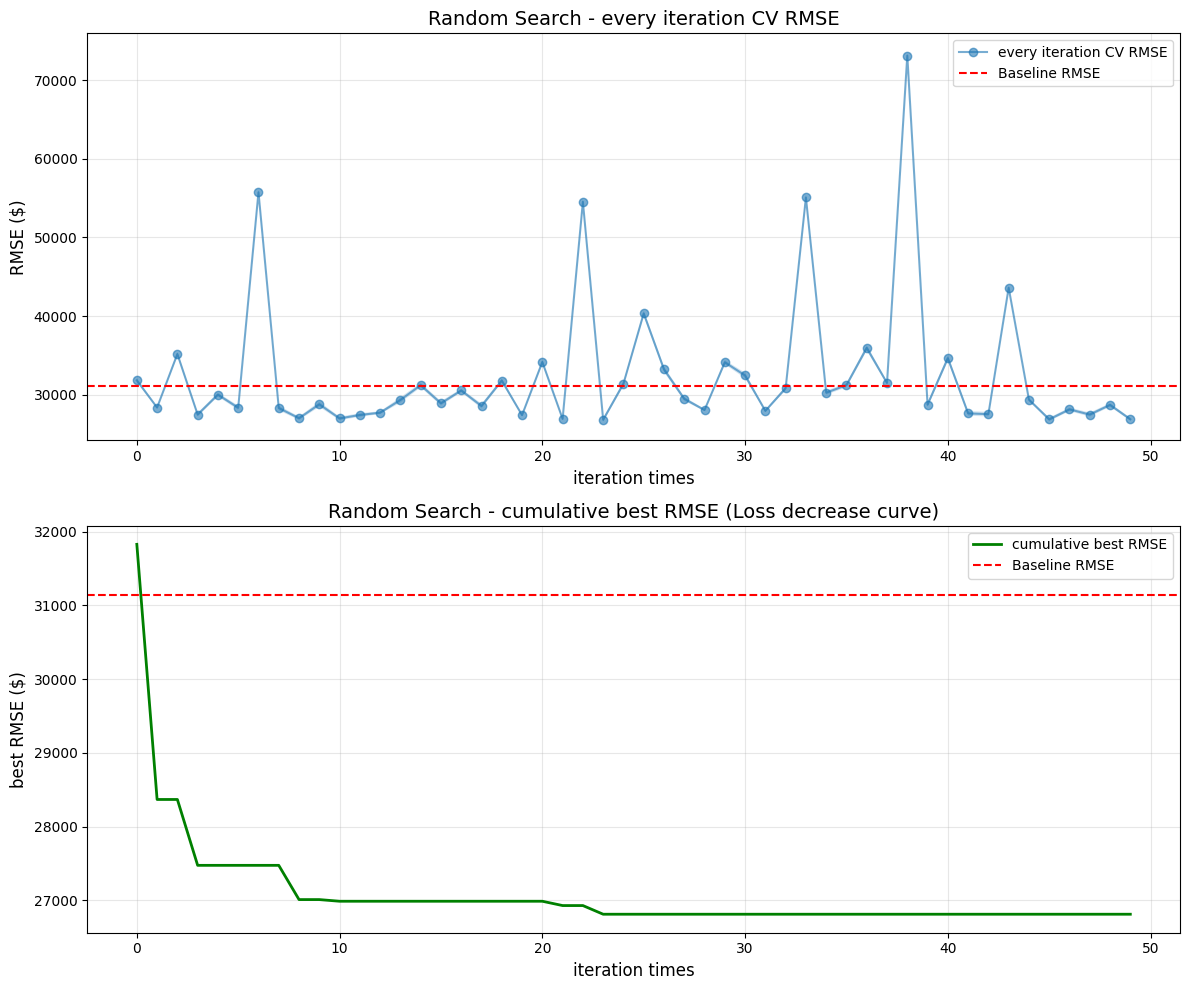

In [11]:
cv_results = pd.DataFrame(random_search.cv_results_)

mean_test_scores = -cv_results['mean_test_score']  
std_test_scores = cv_results['std_test_score']

cumulative_best = np.minimum.accumulate(mean_test_scores)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(range(len(mean_test_scores)), mean_test_scores, 'o-', alpha=0.6, label='every iteration CV RMSE')
axes[0].fill_between(range(len(mean_test_scores)), 
                      mean_test_scores - std_test_scores,
                      mean_test_scores + std_test_scores, 
                      alpha=0.2)
axes[0].axhline(y=31133.04, color='r', linestyle='--', label='Baseline RMSE')
axes[0].set_xlabel('iteration times', fontsize=12)
axes[0].set_ylabel('RMSE ($)', fontsize=12)
axes[0].set_title('Random Search - every iteration CV RMSE', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(range(len(cumulative_best)), cumulative_best, 'g-', linewidth=2, label='cumulative best RMSE')
axes[1].axhline(y=31133.04, color='r', linestyle='--', label='Baseline RMSE')
axes[1].set_xlabel('iteration times', fontsize=12)
axes[1].set_ylabel('best RMSE ($)', fontsize=12)
axes[1].set_title('Random Search - cumulative best RMSE (Loss decrease curve)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




=== Top 20 Features (After Tuning) ===
                        feature  importance
5             FLAT_TYPE_ENCODED    0.175964
79            GEO_AVG_PRICE_K16    0.130551
81            GEO_AVG_PRICE_K32    0.058147
83            GEO_AVG_PRICE_K64    0.058073
1              TRANSACTION_YEAR    0.044933
8      FLAT_MODEL_adjoined flat    0.034383
66           HAWKER_COUNT_3.0KM    0.029622
25           FLAT_MODEL_type s1    0.029617
24           FLAT_MODEL_terrace    0.027002
0                FLOOR_AREA_SQM    0.025605
22        FLAT_MODEL_simplified    0.023084
18    FLAT_MODEL_new generation    0.020918
14           FLAT_MODEL_model a    0.020039
13        FLAT_MODEL_maisonette    0.017419
9          FLAT_MODEL_apartment    0.017082
17  FLAT_MODEL_multi generation    0.014224
55                    MAX_FLOOR    0.012868
34            TOWN_central area    0.012337
65           HAWKER_COUNT_1.5KM    0.010528
6             FLAT_MODEL_2 room    0.009879


<Figure size 1000x800 with 0 Axes>

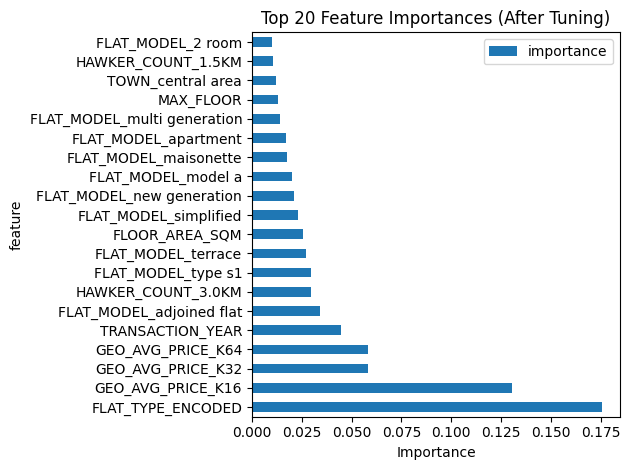

In [12]:
feature_importance_tuned = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model_random.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 20 Features (After Tuning) ===")
print(feature_importance_tuned.head(20))
plt.figure(figsize=(10, 8))
feature_importance_tuned.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Feature Importances (After Tuning)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [13]:
##Fit model with random searched best parameters on test data
df_test=pd.read_csv(datapath+'test_data_for_modeling(no_standardization).csv')
X_test=df_test[feature_cols]

best_model_random.fit(X_train,y_train)
y_pred_test=best_model_random.predict(X_test)
print(f'XGBoost model with random search best parameters on test data completed!')
print(f'predicted test data amount: {len(y_pred_test)}')
print(f'predicted test data range: {y_pred_test.min()} to {y_pred_test.max()}')
print(f'predicted test data mean: {y_pred_test.mean():,.2f}')
submission = pd.DataFrame({
    'Id': range(len(y_pred_test)),
    'Predicted': y_pred_test
})
submission.to_csv(datapath+'XGBoost_random_search_submission.csv', index=False)

XGBoost model with random search best parameters on test data completed!
predicted test data amount: 50000
predicted test data range: 176069.78125 to 1546956.375
predicted test data mean: 517,727.31


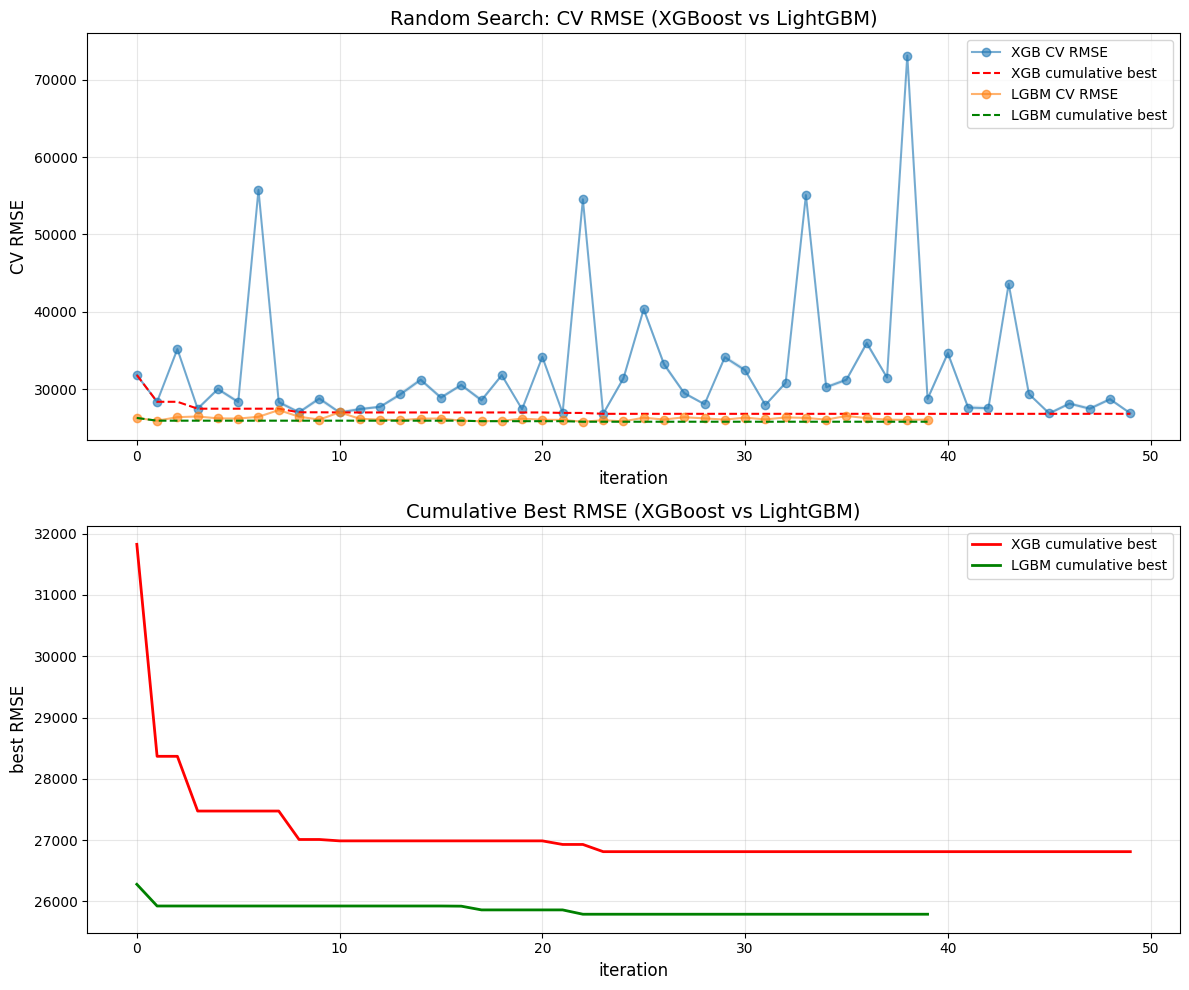

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

root = Path('/Users/yangkexin/Documents/CS5228/Project/cs5228_PROJ/Models/LightGBM_notebook')
cv_xgb  = pd.read_csv(root/'xgb_cv_results.csv')
cv_lgbm = pd.read_csv(root/'lgbm_cv_results.csv')

def to_curves(df):
    mean = -df['mean_test_score'].to_numpy()      # neg RMSE -> RMSE
    std  =  df['std_test_score'].to_numpy()
    best = np.minimum.accumulate(mean)
    return mean, std, best

xgb_mean, xgb_std, xgb_best   = to_curves(cv_xgb)
lgbm_mean, lgbm_std, lgbm_best = to_curves(cv_lgbm)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (1) every iteration CV RMSE + error band + cumulative best
ax = axes[0]
ax.plot(range(len(xgb_mean)), xgb_mean, 'o-', alpha=0.6, label='XGB CV RMSE')
ax.fill_between(range(len(xgb_mean)), xgb_mean-xgb_std, xgb_mean+xgb_std, alpha=0.12)
ax.plot(range(len(xgb_best)), xgb_best, 'r--', linewidth=1.5, label='XGB cumulative best')

ax.plot(range(len(lgbm_mean)), lgbm_mean, 'o-', alpha=0.6, label='LGBM CV RMSE')
ax.fill_between(range(len(lgbm_mean)), lgbm_mean-lgbm_std, lgbm_mean+lgbm_std, alpha=0.12)
ax.plot(range(len(lgbm_best)), lgbm_best, 'g--', linewidth=1.5, label='LGBM cumulative best')

ax.set_xlabel('iteration', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Random Search: CV RMSE (XGBoost vs LightGBM)', fontsize=14)
ax.grid(True, alpha=0.3); ax.legend()

# (2) cumulative best comparison (zoom in)
ax2 = axes[1]
ax2.plot(range(len(xgb_best)), xgb_best, 'r-', linewidth=2, label='XGB cumulative best')
ax2.plot(range(len(lgbm_best)), lgbm_best, 'g-', linewidth=2, label='LGBM cumulative best')
ax2.set_xlabel('iteration', fontsize=12)
ax2.set_ylabel('best RMSE', fontsize=12)
ax2.set_title('Cumulative Best RMSE (XGBoost vs LightGBM)', fontsize=14)
ax2.grid(True, alpha=0.3); ax2.legend()

plt.tight_layout(); plt.show()